In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

### Step 1: Load the Image and Mask
First, load your image and mask files as arrays. Make sure the mask has the same spatial dimensions as the image.

In [2]:
# Load image
img_file = "data/ang20190712t231624_rfl_v2v2_img_cutline_V3_BIL"
img = gdal.Open(img_file)
img_array = img.ReadAsArray()

# Load mask
mask_file = "mask/savi_above_008"
mask = gdal.Open(mask_file)
mask_array = mask.ReadAsArray()


### Step 2: Ensure the Mask Has the Correct Format
To work correctly as a mask, the mask should have a binary structure (e.g., 1 for pixels to keep, 0 for pixels to discard). If not, convert it to binary.

In [3]:
# Ensure the mask is binary (e.g., mask pixels > 0 are set to 1)
mask_array = np.where(mask_array > 0, 1, 0)

### Step 3: Apply the Mask to the Image
Using NumPy, apply the mask to retain only the areas where the mask is set to 1.

In [4]:
# Ensure the mask has the same shape as the image
if mask_array.shape != img_array.shape[1:]:  # Assuming img_array has bands, rows, cols
    raise ValueError("Image and mask dimensions do not match!")

# Apply mask to each band of the image (assuming it's a multi-band image)
masked_img = img_array * mask_array  # This masks out all pixels where the mask is 0

### Step 4: Save the Masked Image (Optional)
To save the masked image as a new file, you can use GDAL.

In [5]:
output_file = "result/masked_image.tif"
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(output_file, img.RasterXSize, img.RasterYSize, img.RasterCount, gdal.GDT_Float32)
out_ds.SetGeoTransform(img.GetGeoTransform())
out_ds.SetProjection(img.GetProjection())

# Write each band with the mask applied
for i in range(img.RasterCount):
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(masked_img[i, :, :])
    out_band.FlushCache()

out_ds = None  # Close the dataset
print("Masked image saved.")


Masked image saved.


In [7]:
output_file = "result/masked_image_V2.tif"
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(output_file, img.RasterXSize, img.RasterYSize, img.RasterCount, gdal.GDT_Float32)
out_ds.SetGeoTransform(img.GetGeoTransform())
out_ds.SetProjection(img.GetProjection())

# Define the NoData value to use (e.g., 0 for black frame, or adjust as needed)
no_data_value = 0

# Write each band with the mask applied and set NoData value
for i in range(img.RasterCount):
    out_band = out_ds.GetRasterBand(i + 1)
    masked_band = masked_img[i, :, :]

    # Set the black frame pixels (e.g., where pixel values are 0) to NoData
    masked_band[masked_band == no_data_value] = np.nan

    # Write the array to the output file
    out_band.WriteArray(masked_band)
    out_band.SetNoDataValue(no_data_value)  # Set the NoData value for the band
    out_band.FlushCache()

out_ds = None  # Close the dataset
print("Masked image saved without black frame.")

Masked image saved without black frame.


### Step 5: Visualize the Masked Image
You can visualize the masked image using Matplotlib.

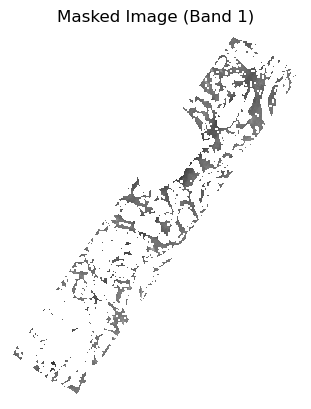

In [8]:
# Plot the first band as an example (adjust according to the number of bands)
plt.imshow(masked_img[0, :, :], cmap="gray")
plt.title("Masked Image (Band 1)")
plt.axis("off")
plt.show()
